In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d
mpl.rc('font', family='serif', size=12)
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['ytick.major.size'] = 5

mpl.rcParams['axes.titlesize'] = 14
mpl.rcParams['axes.labelsize'] = 14
mpl.rc('axes', titlesize=12)

# RF, LO Mixing Simulation for Filter Bank Selection and other work
This notebook is meant to simulate the readout chain for the VNA, but not the actual circuitry.

This includes generation of RF and LO waves, their mixing, filtering, readout and measurement. The idea is that this can be used to help filter bank selection, since we can get an idea of the effects of different filters at a given measurement frequency on the actual measurement, rather than just guessing.

Perhaps, this simulation set can eventually be used in a more detailed simulation of the VNA circuitry eventually too.

## Generating realistic RF waves for simulation
These will be "dirty" square waves, aka with even harmonics which can be tuned via offsetting the duty cycle from 50%

Text(0, 0.5, 'Magnitude (dB)')

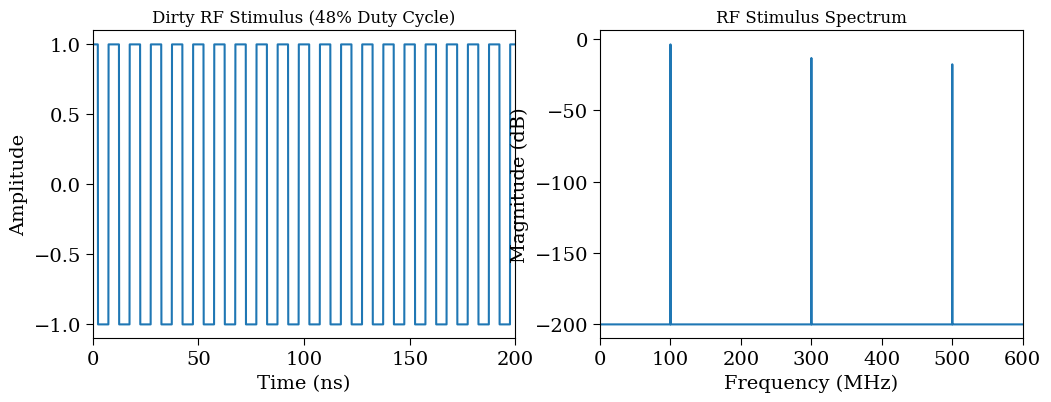

In [174]:
#  Parameters 
fs = 10e9        # 10 GHz Sample rate (to see high harmonics)
duration = 5000e-9 # 5 us
t = np.arange(0, duration, 1/fs)

def create_sq_wave(freq, duty_cycle=0.5, phase_deg=0, fs=10e9, duration=5e-6):
    t = np.arange(0, duration, 1/fs)
    phase_rad = np.radians(phase_deg)
    #begin with cos wave so that phase is always centered
    h = np.cos(np.pi * duty_cycle)
    sq_wave_raw = (np.cos(2 * np.pi * freq * t + phase_rad) > h).astype(float)
    
    # Fundamental magnitude recovery: 
    # The amplitude of the fundamental of a pulse train is (2/pi) * sin(pi * D)
    fundamental_amp = (2 / np.pi) * np.sin(np.pi * duty_cycle)
    
    # Scale the wave so the fundamental component is always 1.0
    sq_wave = sq_wave_raw/ np.max(np.abs(sq_wave_raw)) - 0.5

    return t,2*sq_wave

def get_fft(rf_raw):
    fft_vals = np.fft.rfft(rf_raw)
    freqs = np.fft.rfftfreq(len(rf_raw), 1/fs)
    mags = 20 * np.log10(np.abs(fft_vals) / len(rf_raw) + 1e-10) # dB scale
    return freqs, mags
    
t, rf_raw = create_sq_wave(100e6, duty_cycle=0.5, phase_deg=1)    
# Calculate Spectrum
freqs,mags=get_fft(rf_raw)

# Visualize the Waves
fig,axs=plt.subplots(1,2, figsize=(12,4))
axs[0].plot(t * 1e9, rf_raw)
axs[0].set_title("Dirty RF Stimulus (48% Duty Cycle)")
axs[0].set_xlabel("Time (ns)")
axs[0].set_ylabel("Amplitude")
axs[0].set_xlim(0,200)

axs[1].plot(freqs / 1e6, mags)
axs[1].set_xlim(0, 600) # Look at first 6 harmonics
axs[1].set_title("RF Stimulus Spectrum")
axs[1].set_xlabel("Frequency (MHz)")
axs[1].set_ylabel("Magnitude (dB)", loc='center')


## Mixing
During mixing of two waves, the two waves are simply multiplied by each other

Text(0, 0.5, 'Magnitude (dB)')

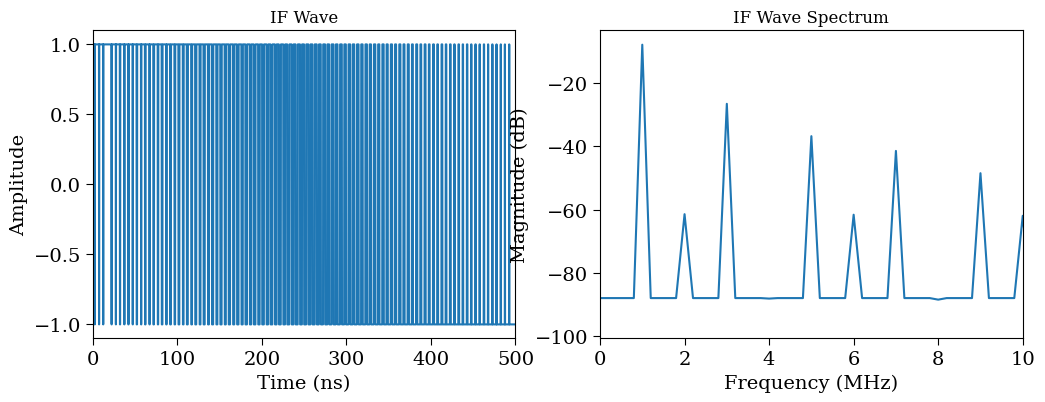

In [177]:
def mix(rf_in, LO_in):
    return rf_in * LO_in
# Let's define our Local Oscillator signal to get an IF of 1 MHz
t, LO_raw = create_sq_wave(101e6, duty_cycle=0.48)
IF_raw = mix(rf_raw, LO_raw)
freqs,mags=get_fft(IF_raw)

fig,axs=plt.subplots(1,2, figsize=(12,4))
axs[0].plot(t * 1e9, IF_raw)
axs[0].set_title("IF Wave")
axs[0].set_xlabel("Time (ns)")
axs[0].set_ylabel("Amplitude")
axs[0].set_xlim(0,500)

axs[1].plot(freqs / 1e6, mags)
axs[1].set_xlim(0, 10) # Look at first 6 harmonics
axs[1].set_title("IF Wave Spectrum")
axs[1].set_xlabel("Frequency (MHz)")
axs[1].set_ylabel("Magnitude (dB)", loc='center')


## LPF
These waves are kinda a mess, let's do some filtering to extract the 1 MHz signal we want.

Now, we could do an ideal butterworth-type filter, but I think it will be more useful to define our LPF in terms of the different frequency bands (F1, F2, F3 and F4) and their attenuation levels, which is how an LPF vendor might define it.
Thus, this can be used to model the final Filter Bank

Text(0, 0.5, 'Magnitude (dB)')

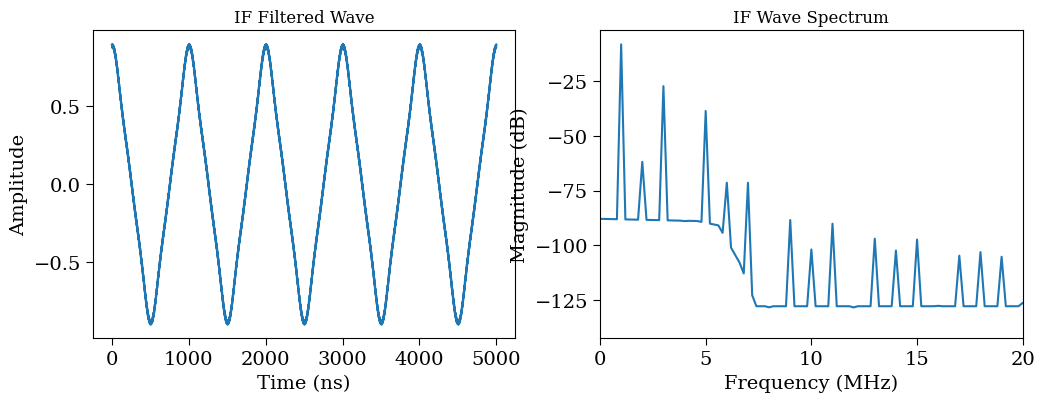

In [178]:
def apply_LPF(data, fs, filter_freqs, f1_att=-1, f2_att=-3, f3_att=-20, f4_att=-40):
    # frequency in terms of Hz,attenuation in db
    f1,f2,f3,f4 = filter_freqs
    
    #Perform FFT to get frequency components
    n = len(data)
    freqs = np.fft.rfftfreq(n, 1/fs)
    spectrum = np.fft.rfft(data)
    
    #Define the piece-wise attenuation (in dB)
    # We add 0Hz and Nyquist to cover the full range
    freq_points = [0, f1, f2, f3, f4, fs/2]
    att_points  = [0, f1_att, f2_att, f3_att, f4_att, f4_att]
    
    # Create interpolation function, then convert dB to linear gain
    interp_func = interp1d(freq_points, att_points, kind='linear', fill_value="extrapolate")
    gain_db = interp_func(freqs)
    gain_linear = 10**(gain_db / 20)
    
    # Apply gain and transform back to time domain
    filtered_spectrum = spectrum * gain_linear
    return np.fft.irfft(filtered_spectrum, n)

#For the IF signal, let's use the following specs from the SCLF-4.7+ from Mini Circuits
#sclf_4 = (4.6E6, 5.6E6, 6.6E6, 7.4E6)
test_filter = (1E6, 2E6, 3E6, 5E6)
IF_filtered = apply_LPF(IF_raw, fs,sclf_4)
freqs,mags=get_fft(IF_filtered)

fig,axs=plt.subplots(1,2, figsize=(12,4))
axs[0].plot(t * 1e9, IF_filtered)
axs[0].set_title("IF Filtered Wave")
axs[0].set_xlabel("Time (ns)")
axs[0].set_ylabel("Amplitude")
#axs[0].set_xlim(500,800)

axs[1].plot(freqs / 1e6, mags)
axs[1].set_xlim(0, 20) # Look at first harmonics
axs[1].set_title("IF Wave Spectrum")
axs[1].set_xlabel("Frequency (MHz)")
axs[1].set_ylabel("Magnitude (dB)", loc='center')


Okay, great. So what we've been able to do is take two dirty square waves, mix them down to a lower IF, and then filter out the higher frequencies to get our IF.
One can see that this is a bit messy still. Let's push forward and extract I/Q

## I/Q Extraction


In [103]:
def i_q_meas(t, if_signal, f_if=1E6):
    period_if = 1.0 / f_if
    total_time = t[-1] - t[0]
    num_cycles = int(total_time / period_if)
    
    # Trim the signal to an exact integer number of cycles, necessary 
    num_samples = int(num_cycles * period_if * (1/(t[1]-t[0])))
    if_trimmed = if_signal[:num_samples]
    t_trimmed = t[:num_samples]

    # Generate references that are PERFECTLY phase-locked to the time vector
    # Use cos/sin starting exactly at t=0
    ref_i = np.cos(2 * np.pi * f_if * t_trimmed)
    ref_q = np.sin(2 * np.pi * f_if * t_trimmed)

    # Integrate
    # Multiplication by 2.0 recovers the 0.5 loss from the cos(A-B) mixing product
    i_comp = np.mean(if_trimmed * ref_i) * 2.0
    q_comp = np.mean(if_trimmed * ref_q) * 2.0
    
    mag = np.sqrt(i_comp**2 + q_comp**2)
    
    # Use -atan2 because LO is (f_rf + f_if), which flips the phase polarity
    phase = np.degrees(np.arctan2(q_comp, i_comp))
    return mag,phase

mag, phase = i_q_meas(t, IF_filtered)
print(f"Measured Magnitude: {mag:.4f}")
print(f"Measured Phase: {phase:.2f}°")

Measured Magnitude: 0.7846
Measured Phase: 1.79°


So, we've demonstrated that we can extract the magnitude and phase from our "dirty" RF wave using this technique. Great...
Let's try doing using these functions to help us pick a filter bank


## Filter Bank Simulations

In [179]:
# first a calibration on "ideal" components
f_if=1E6
f_rf = 100E6

t, rf_ideal_sq = create_sq_wave(f_rf, duty_cycle=0.5, phase_deg=47, fs=10E9)    
t, LO_ideal_sq = create_sq_wave(f_rf+f_if, duty_cycle=0.5, fs=10E9)

IF = mix(rf_ideal_sq, LO_ideal_sq)

mag, phase = i_q_meas(t, IF)

print(f"Measured Magnitude: {mag:.4f}")
print(f"Measured Phase: {phase:.2f}°")

def VNA_meas(f_rf, RF_filter_freqs = None, IF_filter_freqs=(4.6E6, 5.6E6, 6.6E6, 7.4E6), 
             f_if = 1E6, phase_deg=0, RF_duty_cycle=0.5, LO_duty_cycle=0.5, fs=10e9, duration=5e-6):
    
    t, rf_raw = create_sq_wave(f_rf, duty_cycle=RF_duty_cycle, phase_deg=phase_deg, fs=fs, duration=duration)
    t, LO_raw = create_sq_wave(f_rf+f_if, duty_cycle=LO_duty_cycle, phase_deg=0, fs=fs, duration=duration)
    
    if RF_filter_freqs is not None:
        rf_filtered = apply_LPF(rf_raw, fs, RF_filter_freqs)
    else:
        rf_filtered=rf_raw
        
    if_raw = mix(rf_filtered,  LO_raw)
    if_filtered = apply_LPF(if_raw, fs, IF_filter_freqs)

    mag_raw, phase_raw = i_q_meas(t, if_filtered, f_if=f_if)
    return mag_raw, phase_raw

VNA_meas(100E6, phase_deg=0)

Measured Magnitude: 0.8102
Measured Phase: 48.78°


(np.float64(0.786393021189328), np.float64(-1.4939899931153764))

So there's a slight offset in the measurement of the phase to the original. The magnitude I think is expected to be around 0.81 so that's good. After playing around a bit with the sampling frequency, the phase offset is a result of the finite sampling of the RF and LO waves. This shouldn't be a problem since we don't actually sample those waves and is only a result of the digital method here. 

Below, let's now simulate a filter bank scenario. 

Say we have a low frequency band beginning at 100 MHz. We want to determine a LPF that can provide a good measuremnt for this frequency (possibly by suppressing the 3rd harmonic at 300 MHz) and also determine a max frequency that we can use this LPF for.

The problem with using an LPF that filters 300 MHz with any reasonable attenuation (~20 dB) is that the $f_c$ greatly limits our band size. So, instead we rely on another trick: at these low frequencies, our VNA receiver can provide an N=4 division of the LO frequency. The benefit here is that this allows for a duty cycle of the LO frequency to be nearly 50%, removing any dangerous even harmonics. So, we can pick a LPF for this low frequency band that has a much higher cutoff frequency, which increases our band size.

So, let's try this with the LFCN-225+ LPF from MiniCircuits on a 100 MHz Stimulus Frequency and a 1 MHz IF. We'll set the stimulus frequency to be a dirty square wave with duty cycle of 46% and the LO duty cycle to be 50%. 


In [89]:

#lets approximate the LFCN-225+
LFCN_225 = (225e6, 350e6, 460e6, 510e6)
mag, phase = VNA_meas(100E6, RF_filter_freqs=LFCN_225, phase_deg = 0, RF_duty_cycle=0.48, LO_duty_cycle=0.5)
print(mag,phase)

#what happens if LO isn't a perfect square wave?
mag, phase = VNA_meas(100E6, RF_filter_freqs=LFCN_225, phase_deg = 10, RF_duty_cycle=0.48, LO_duty_cycle=0.45)
print(mag,phase)

#what about at higher frequencies?
mag, phase = VNA_meas(225E6, RF_filter_freqs=LFCN_225, phase_deg = 13, RF_duty_cycle=0.48, LO_duty_cycle=0.5)
print(mag,phase)


0.7458569327929014 -1.4738999881807502
0.7356460085683628 9.02875613131109
0.7030600037153134 13.071256150291982


This is interesting... perhaps we need to some sort of normalization against the values without filtering and with a clean duty cycle. Let's do a frequency sweep as well...

In [166]:
freq_sweep = np.arange(50, 1000, 10)*1E6
results_clean=[]
results_dirty=[]
results_dirty_filtered=[]
for freq in freq_sweep:
    results_clean.append(VNA_meas(freq, RF_filter_freqs=None, phase_deg = 0, RF_duty_cycle=0.5, LO_duty_cycle=0.5))
    results_dirty.append(VNA_meas(freq, RF_filter_freqs=None, phase_deg = 0, RF_duty_cycle=0.48, LO_duty_cycle=0.5))
    results_dirty_filtered.append(VNA_meas(freq, RF_filter_freqs=LFCN_225, phase_deg = 0, RF_duty_cycle=0.48, LO_duty_cycle=0.5))
results_clean=np.array(results_clean)
results_dirty=np.array(results_dirty)
results_dirty_filtered=np.array(results_dirty_filtered)

Text(0, 0.5, '$\\Delta\\phi$')

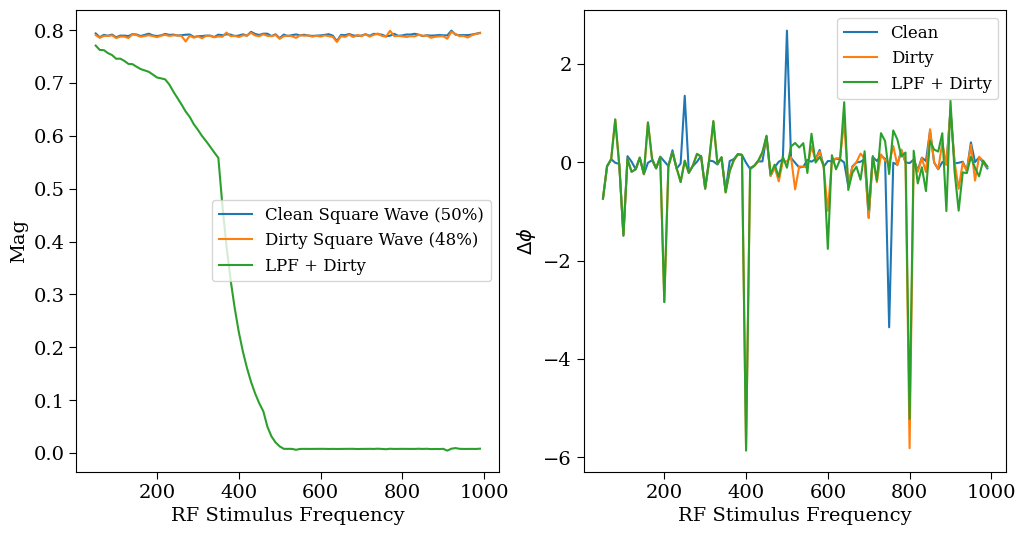

In [167]:
fig,axs=plt.subplots(1,2, figsize=(12,6))
axs[0].plot(freq_sweep/1E6, results_clean[:,0], label='Clean Square Wave (50%)')
axs[0].plot(freq_sweep/1E6, results_dirty[:,0], label='Dirty Square Wave (48%)')
axs[0].plot(freq_sweep/1E6, results_dirty_filtered[:,0], label='LPF + Dirty')
#axs[0].set_xscale('log')
axs[0].legend()
axs[0].set_xlabel('RF Stimulus Frequency')
axs[0].set_ylabel('Mag')

axs[1].plot(freq_sweep/1E6, results_clean[:,1], label='Clean')
axs[1].plot(freq_sweep/1E6, results_dirty[:,1], label='Dirty')
axs[1].plot(freq_sweep/1E6, results_dirty_filtered[:,1], label='LPF + Dirty')
axs[1].legend()
axs[1].set_xlabel('RF Stimulus Frequency')
axs[1].set_ylabel('$\Delta\phi$')
#axs[1].set_xscale('log')

Okay this is weird...